# Experiment 1 plots

### Plot analysis for speech-on-speech and speech-in-noise distractors, presented diotically
### Models run on all combinations of stimuli
___

In [1]:
import pickle
import numpy as np 
import re 
from pathlib import Path
import pandas as pd
import json
import pickle
import importlib 
import IPython.display as ipd
%matplotlib inline 

import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats 

import src.util_process_prolific as up 
from src import util_analysis
from tqdm import tqdm
importlib.reload(up)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Load data


In [2]:
### Load data

# includes summary for all participants and each model architecture (10 feature-gain models + 3 alternates) - need to average individual feature gain models
results_df = pd.read_csv('final_results_to_share/experiment_1_df.csv')

### Merge all feature-gain models into one group - will plot mean and SEM over architectures 
models_to_summary = results_df[results_df.group == "Feature-gain Model"].copy()
fba_summary_df = models_to_summary.groupby(['snr', 'background_condition']).agg({'accuracy':['mean', 'sem'], 'confusions':['mean', 'sem', 'count']}).reset_index()
fba_summary_df.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem', 'N']
fba_summary_df['group'] = 'Feature-gain Model'

# combine model and human data 
human_fba_results = pd.concat([results_df[results_df.group.str.contains("Human")], fba_summary_df], axis=0, ignore_index=True)

In [3]:
fig_out_dir = Path("rebuttal_figs/fig_2")
fig_out_dir.mkdir(exist_ok=True, parents=True)
fig_out_dir

PosixPath('rebuttal_figs/fig_2')

# Make plots

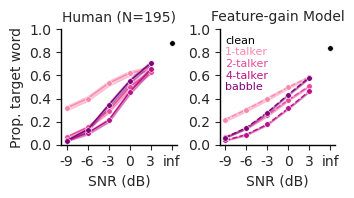

In [4]:
#######################
#    Speech on speech
#######################
to_plot = to_plot = human_fba_results.copy()
sns.set_style('ticks')


hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble'] 
palette={}
palette['clean'] = 'k'

# set speech color gradient 
speech_palette = sns.color_palette("RdPu_r")
speech_order = hue_order[1:][::-1]

for ix, group in enumerate(speech_order):
    palette[group] = speech_palette[ix]

fontsize=10
tick_fontsize = 10

MARKER_SIZE = 8

models = human_fba_results.group.unique()

n_models = len(models)

aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
err_band_alpha = 0.4
# add markers to relplot

x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order = 1


for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        sem = selected['acc_sem'] * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['accuracy'] - sem,
                         selected['accuracy'] + sem, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
        line.set_linewidth(1)
        line.set_markersize(MARKER_SIZE)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)


for ix, group in enumerate(hue_order):
    axs[1].text(-9, 0.9 - ix * 0.1, group, color=palette[group], fontsize=8, ha='left', va='center')

# plt.savefig(fig_out_dir/'human_v_model_acc_speech_only.pdf', transparent=True, bbox_inches='tight')

# adjust w space 

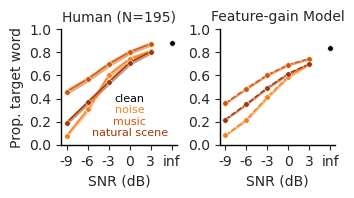

In [5]:
#######################
#    Speech in noise
#######################
to_plot = human_fba_results.copy()
sns.set_style('ticks')

hue_order = ['clean', 'noise',  'music', 'natural scene']

# set noise color gradient 
noise_palette = sns.color_palette("YlOrBr_r", n_colors=6)
noise_order = hue_order[1:][::-1]

for ix, group in enumerate(noise_order):
    palette[group] = noise_palette[ix]

fontsize=10
tick_fontsize = 10

models = human_fba_results.group.unique()

n_models = len(models)

aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
err_band_alpha = 0.4
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order = 1


for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        sem = selected['acc_sem'] * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['accuracy'] - sem,
                         selected['accuracy'] + sem, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
        line.set_linewidth(1)
        line.set_markersize(MARKER_SIZE)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
sns.despine()
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# add text as legend to panel 1
for ix, group in enumerate(hue_order):
    axs[0].text(0, 0.4 - ix * 0.1, group, color=palette[group], fontsize=8, ha='center', va='center')


# plt.savefig(fig_out_dir/'human_v_model_acc_noise_only.pdf', transparent=True, bbox_inches='tight')
# 


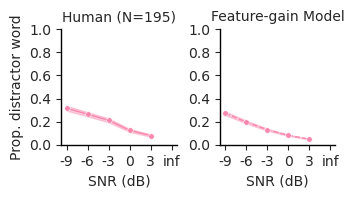

In [6]:
###############################
# Speech on Speech confusions
###############################
to_plot = human_fba_results.copy()
sns.set_style('ticks')

hue_order = ['1-talker']
fontsize=10
tick_fontsize = 10

aspect = 1.5
n_models = len(models)
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))

err_band_alpha = 0.4
# add markers to relplot
models = human_fba_results.group.unique()

x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order = 1

for ax, model in zip(axs, models):
    ax.plot(x_tick_locs, np.ones(len(x_tick_locs)) * 0.5, 'w', alpha=0.5, label=None)

    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='confusions', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        sem = selected['conf_sem'] * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['confusions'] - sem,
                         selected['confusions'] + sem, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
        line.set_linewidth(1)
        line.set_markersize(MARKER_SIZE)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
sns.despine()
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. distractor word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# plt.savefig(fig_out_dir/'human_v_model_conf_english.pdf', transparent=True, bbox_inches='tight')


Text(-8, 0.1, 'Different-sex distractor')

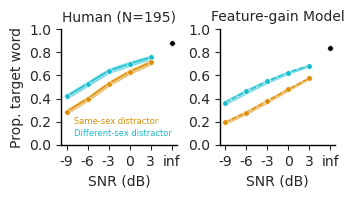

In [7]:
##############################
# Distractor sex accuracy
##############################
to_plot = human_fba_results.copy()

hue_order = ['Different', 'Same', 'clean']

palette = dict(zip(hue_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['clean'] = 'k'
palette['Different'] = 'tab:cyan'

fontsize=10
tick_fontsize = 10

models = to_plot.group.unique()

n_models = len(models)
aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
sem_order = 1

err_band_alpha = 0.4
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        sem = selected['acc_sem'] * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['accuracy'] - sem,
                         selected['accuracy'] + sem, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
        line.set_linewidth(1)
        line.set_markersize(MARKER_SIZE)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')
    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
# turn off axs[0] legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

axs[0].text(-8, 0.2, "Same-sex distractor", color=palette["Same"], fontsize=6, ha='left', va='center')
axs[0].text(-8, 0.1, "Different-sex distractor", color=palette["Different"], fontsize=6, ha='left', va='center')


# plt.savefig(fig_out_dir/'human_model_same_diff_sex_acc.pdf', transparent=True, bbox_inches='tight')



Text(-9, 0.8, 'Different-sex distractor')

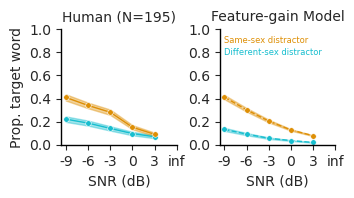

In [8]:
##############################
# Distractor sex confusions
##############################
to_plot = human_fba_results.copy() #combined_dist_sex_results.copy()

hue_order = ['Different', 'Same', 'Clean']

palette = dict(zip(hue_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Clean'] = 'k'
palette['Different'] = 'tab:cyan'

fontsize=10
tick_fontsize = 10

models = to_plot.group.unique()

n_models = len(models)
aspect = 1.5
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))
sem_order = 1

err_band_alpha = 0.4
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='confusions', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        sem = selected['conf_sem'] * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['confusions'] - sem,
                         selected['confusions'] + sem, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
        line.set_linewidth(1)
        line.set_markersize(MARKER_SIZE)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')
    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
sns.despine()
# turn off axs legend 
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)


axs[1].text(-9, 0.9, "Same-sex distractor", color=palette["Same"], fontsize=6, ha='left', va='center')
axs[1].text(-9, 0.8, "Different-sex distractor", color=palette["Different"], fontsize=6, ha='left', va='center')

# plt.savefig(fig_out_dir/'human_model_same_diff_sex_conf.pdf', transparent=True, bbox_inches='tight')



## Run stats on confusions

In [25]:
from pingouin import rm_anova

df_for_anova = pd.read_csv("final_results_to_share/summary_2024_SWC_diotic_same_v_diff_sex_confusions_indiv_participant_results_195.csv")
to_anova = df_for_anova[df_for_anova.sex_cond.isin(["Same", "Different"])].copy()
human_rm_anova_table = rm_anova(data=to_anova, dv='adjusted_confusions_mean', subject='id_subject', within=["snr", "sex_cond"], effsize='np2')
print("ANOVA for humans")
human_rm_anova_table

ANOVA for humans


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,snr,14.739316,4,776,3.684829,51.707947,1.263796e-38,3.715776e-35,0.210445,0.903461
1,sex_cond,6.037051,1,194,6.037051,89.107739,1.205725e-17,1.205725e-17,0.314749,1.000000
2,snr * sex_cond,1.940798,4,776,0.485199,7.838925,3.397410e-06,6.459883e-06,0.038838,0.933941


In [ ]:
# --- bootstrap CIs for partial eta squared ---
import warnings
warnings.filterwarnings(
      "ignore",
      category=FutureWarning,
  )
print("\nBootstrapping partial η² confidence intervals...")
np.random.seed(123) 

n_bootstrap = 2000
subjects = to_anova["id_subject"].unique()
bootstrap_np2 = {src: [] for src in human_rm_anova_table["Source"]}

for _ in tqdm(range(n_bootstrap), desc="Partial η² bootstrap"):
    sampled_ids = np.random.choice(subjects, size=len(subjects), replace=True)
    boot_df = to_anova[to_anova["id_subject"].isin(sampled_ids)].copy()

    try:
        boot_table = rm_anova(
            data=boot_df,
            dv="adjusted_confusions_mean",
            subject="id_subject",
            within=["snr", "sex_cond"],
            effsize="np2",
        )
        for src, np2 in zip(boot_table["Source"], boot_table["np2"]):
            bootstrap_np2[src].append(np2)
    except Exception:
        continue  # skip rare failed fits

alpha = 0.05
lower = alpha / 2 * 100
upper = (1 - alpha / 2) * 100

human_rm_anova_table["np2_CI_lower"] = [
    np.percentile(bootstrap_np2[src], lower) if bootstrap_np2[src] else np.nan
    for src in human_rm_anova_table["Source"]
]
human_rm_anova_table["np2_CI_upper"] = [
    np.percentile(bootstrap_np2[src], upper) if bootstrap_np2[src] else np.nan
    for src in human_rm_anova_table["Source"]
]

print("\nPartial η² with 95% CIs")
display(human_rm_anova_table)


Bootstrapping partial η² confidence intervals...

Partial η² with 95% CIs


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps,np2_CI_lower,np2_CI_upper
0,snr,14.739316,4,776,3.684829,51.707947,1.263796e-38,3.715776e-35,0.210445,0.903461,0.176529,0.247573
1,sex_cond,6.037051,1,194,6.037051,89.107739,1.205725e-17,1.205725e-17,0.314749,1.000000,0.248187,0.394210
2,snr * sex_cond,1.940798,4,776,0.485199,7.838925,3.397410e-06,6.459883e-06,0.038838,0.933941,0.023176,0.066272


Text(-9, 0.8, 'Mandarin distractor')

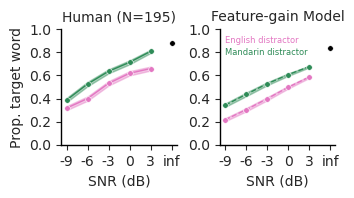

In [9]:
################################
# Distractor language accuracy
################################

to_plot = human_fba_results.copy()

cmap = sns.color_palette("gnuplot2", n_colors=3)

hue_order = ['clean','Mandarin' , 'English',]
hue_plot_order = ['clean', 'English', 'Mandarin']

palette = {lang:cmap[ix] for ix, lang in enumerate(hue_order[1:])}
palette['clean'] = 'k'
palette['English'] = 'tab:pink'
palette['Mandarin'] = 'seagreen'

fontsize=10
tick_fontsize = 10

models = to_plot.group.unique()

n_models = len(models)
fig, axs = plt.subplots(1, 2, figsize=((aspect) * 2.5 , aspect ))


err_band_alpha = 0.4
# add markers to relplot
x_tick_locs = to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1
sem_order
for ax, model in zip(axs, models):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='snr', y='accuracy', hue='background_condition', hue_order=hue_plot_order,
                  palette=palette, ax=ax,
                  errorbar=('se', sem_order), err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = to_plot[to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_plot_order:
            continue
        # plot the errorbar with the correct color for each group 
        selected['acc_sem'] = selected['acc_sem'] * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['accuracy'] - selected['acc_sem'],
                         selected['accuracy'] + selected['acc_sem'], color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
        line.set_linewidth(1)
        line.set_markersize(MARKER_SIZE)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')


sns.despine()
for ix in range(n_models):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

axs[1].text(-9, 0.9, "English distractor", color=palette["English"], fontsize=6, ha='left', va='center')
axs[1].text(-9, 0.8, "Mandarin distractor", color=palette["Mandarin"], fontsize=6, ha='left', va='center')


# set space between pannels 
# plt.savefig(fig_out_dir/'human_model_unfamiliar_language.pdf', transparent=True, bbox_inches='tight')



### Supplement with individual model performance 

In [55]:
import re 

def get_model_str(model):
    if 'early' in model:
        return 'Early-only'
    elif 'late' in model:
        return 'Late-only'
    elif 'control' in model:
        return 'Baseline CNN'
    elif '50Hz' in model:
        return '50Hz cutoff'
    elif 'main' in model:
        return 'Feature-gain Model'
    elif 'arch' in model:
        version_int = re.search(r'arch_(\d+)', model).group(1)
        return f'Feature-gain alt v{version_int}'
    else:
        return model

In [56]:
# Get palette for all tasks 
hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'noise',  'music', 'natural scene',  'Mandarin', "Same", "Different"]

palette={}
palette['clean'] = 'k'
# set speech color gradient 
speech_palette = sns.color_palette("RdPu_r")
speech_order = hue_order[1:5][::-1]
for ix, group in enumerate(speech_order):
    palette[group] = speech_palette[ix]

# set noise color gradient 
noise_palette = sns.color_palette("YlOrBr_r", n_colors=6)
noise_order = hue_order[5:8][::-1]
for ix, group in enumerate(noise_order):
    palette[group] = noise_palette[ix]

# set sex palette 
sex_color = dict(zip(hue_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Different'] = 'tab:cyan'
palette['Same'] =  (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)

# set langauge palette 
palette['English'] = 'tab:pink'
palette['Mandarin'] = 'seagreen'

In [57]:
fig_out_dir = Path("final_figures/sup_fig_1")
fig_out_dir.mkdir(exist_ok=True, parents=True)

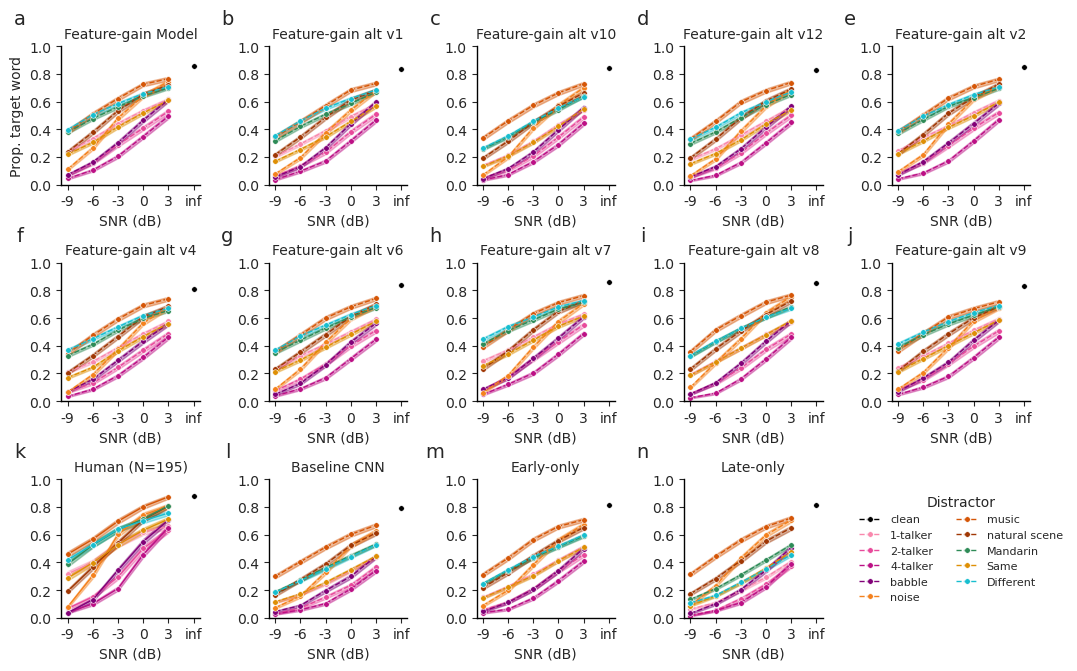

In [58]:

sns.set_style('ticks')
hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'noise',  'music', 'natural scene',  'Mandarin', "Same", "Different"]


fontsize=10
tick_fontsize = 10
# fontsize = 10

all_models = results_df.model.unique()


err_band_alpha = 0.4
# add markers to relplot
model_order = [f'Human (N=195)',
                'word_task_v10_control_no_attn',
                'word_task_early_only_v10', 
                'word_task_late_only_v10',
                # 'word_task_half_co_loc_v09_50Hz_cutoff'
                ]
also_sort = [m for m in all_models if m not in model_order and '50Hz' not in m and 'main' not in m and 'backbone' not in m]
feature_gain_models = ['word_task_v10_main_feature_gain_config'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))
model_order = feature_gain_models + model_order 


aspect = 2.5
sem_order = 1 
n_models = len(model_order)
n_cols = 5 #(n_models // n_rows)
n_rows = int(np.ceil(n_models / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=((aspect) * n_cols , aspect * n_rows))
axs = axs.flatten()


x_tick_locs = results_df.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, model_order):
    sns.lineplot(data=results_df[results_df.model == model],
                 x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=None,
                #   errorbar=('se', 2), err_style='band',
                #     err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = results_df[results_df['model'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        error = selected['acc_sem'].values * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'].values, selected['accuracy'].values - error,
                         selected['accuracy'].values + error, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(get_model_str(model), fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(MARKER_SIZE)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
sns.despine()
for ix in range(n_models):
    if ix == 0:
        handles, labels = axs[0].get_legend_handles_labels()
    axs[ix].legend().remove()
for ix in range(1,len(axs)):
    axs[ix].set_ylabel("", fontsize=fontsize)
# for ix in range(len(axs)):
    # if ix > n_models - 1:
        # axs[ix].set_visible(False)

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
# add panel lettering to top left of each pannel
for ix, ax in enumerate(axs):
    if ix < n_models:
        ax.text(-0.3, 1.2, f'{chr(97+ix)}', transform=ax.transAxes, fontsize=fontsize+4, va='center', ha='center')


# add legend to last pannel
axs[-1].axis("off")
axs[-1].legend(handles, labels, title='Distractor', loc='center', fontsize=8, ncol=2, frameon=False)


# adjust space between pannels
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# plt.savefig(fig_out_dir/'indiv_models_experiment_1.pdf', transparent=True, bbox_inches='tight')

# adjust w space 